In [ ]:
!nvidia-smi

Sat Jul 31 03:04:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!cd ../; git clone -b master https://github.com/iamyyw/vilio.git
!cd ../vilio/py-bottom-up-attention; pip install -r requirements.txt
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!cd ../vilio/py-bottom-up-attention; python setup.py build develop
!pip install detectron2

In [ ]:
#make sure you create such folder with a few sample imgs
data_path = '"/content/drive/MyDrive/Colab Notebooks/data/img"'

In [ ]:
!cp -r $data_path ../vilio/py*/data/

In [ ]:
!cd ../vilio/py-bottom-up-attention; bash hm_feats.bash

Config '/vilio/py-bottom-up-attention/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

faster_rcnn_from_caffe_attr.pkl: 262MB [00:08, 31.3MB/s]               
100

In [ ]:
# Interrupting here
!cd ../vilio/py*/data; ls

hm_vg10100.tsv	hm_vgattr10100.tsv  hm_vgattr5050.tsv  img
hm_vg5050.tsv	hm_vgattr3636.tsv   hm_vgattr7272.tsv  README.md


In [ ]:
import os,sys
import io
sys.path.insert(0,'/vilio/py-bottom-up-attention')

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#load config and predictor
import detectron2
from detectron2.config import downgrade_config, get_cfg, upgrade_config
cfg = get_cfg()
cfg.merge_from_file("/vilio/py-bottom-up-attention/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Config '/vilio/py-bottom-up-attention/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



In [ ]:
# Load VG Classes
vg_classes = []
with open(os.path.join(r"/vilio/py-bottom-up-attention/demo/data/genome/1600-400-20", 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

MetadataCatalog.get("vg").thing_classes = vg_classes

In [ ]:
#load generated tsv file

import sys
import csv
import base64
import time

import numpy as np

csv.field_size_limit(sys.maxsize)
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]


def load_obj_tsv(fname, topk=None):
    """Load object features from tsv file.

    :param fname: The path to the tsv file.
    :param topk: Only load features for top K images (lines) in the tsv file.
        Will load all the features if topk is either -1 or None.
    :return: A list of image object features where each feature is a dict.
        See FILENAMES above for the keys in the feature dict.
    """
    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)

            data.append(item)
            if topk is not None and len(data) == topk:
                break
    elapsed_time = time.time() - start_time
    print("Loaded %d images in file %s in %d seconds." % (len(data), fname, elapsed_time))
    return data

data = load_obj_tsv("/vilio/py-bottom-up-attention/data/hm_vgattr7272.tsv")

Start to load Faster-RCNN detected objects from /vilio/py-bottom-up-attention/data/hm_vgattr7272.tsv
Loaded 8 images in file /vilio/py-bottom-up-attention/data/hm_vgattr7272.tsv in 0 seconds.


/content/drive/MyDrive/Colab Notebooks/data/img/16395.png


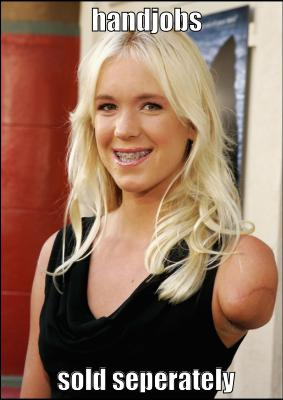

Original image size:  (400, 283)
Transformed image size:  (1131, 800)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


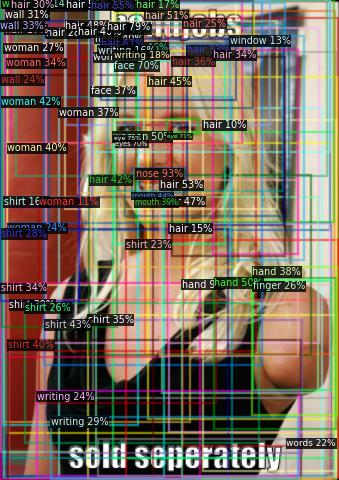

/content/drive/MyDrive/Colab Notebooks/data/img/15740.png


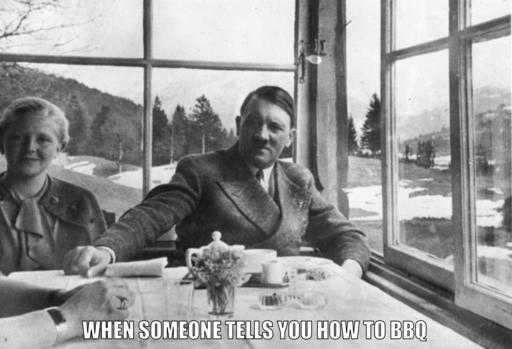

Original image size:  (349, 512)
Transformed image size:  (800, 1174)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


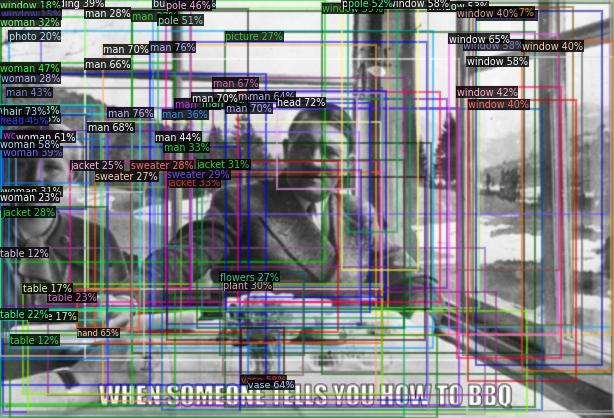

/content/drive/MyDrive/Colab Notebooks/data/img/08291.png


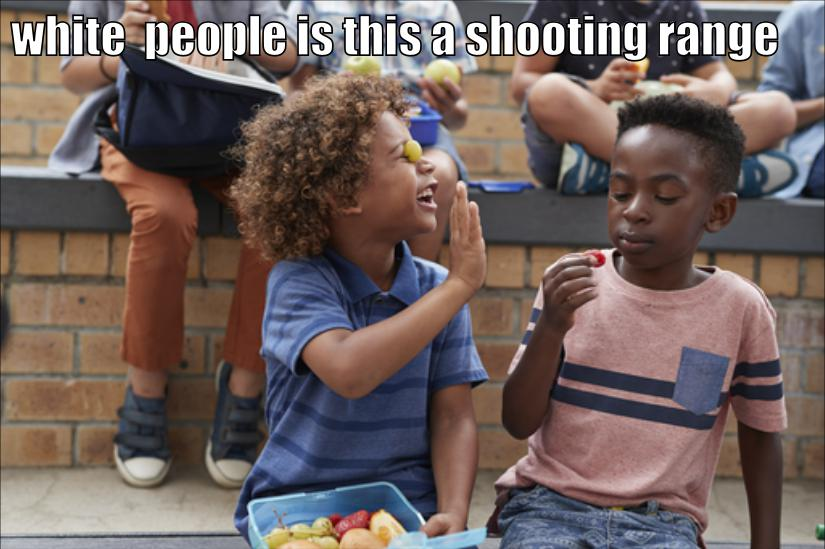

Original image size:  (549, 825)
Transformed image size:  (800, 1202)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


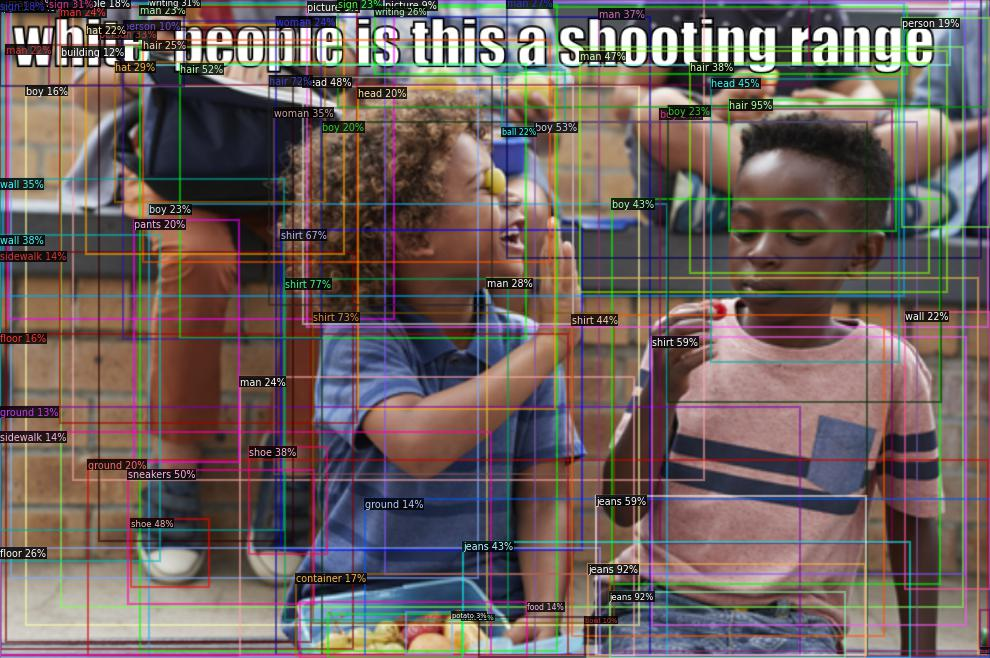

/content/drive/MyDrive/Colab Notebooks/data/img/46971.png


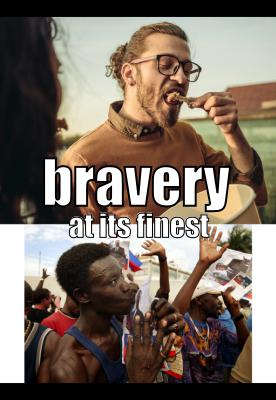

Original image size:  (400, 276)
Transformed image size:  (1159, 800)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


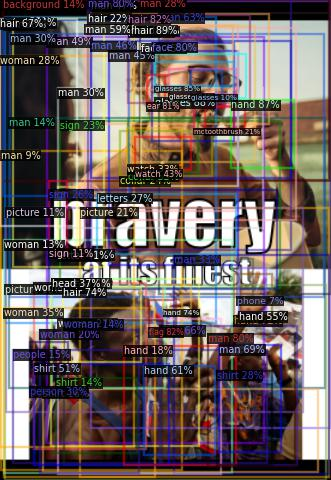

/content/drive/MyDrive/Colab Notebooks/data/img/37405.png


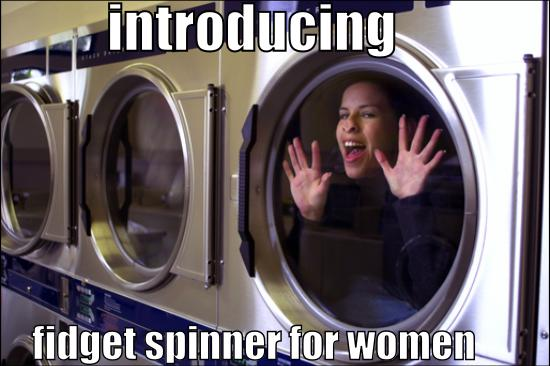

Original image size:  (366, 550)
Transformed image size:  (800, 1202)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


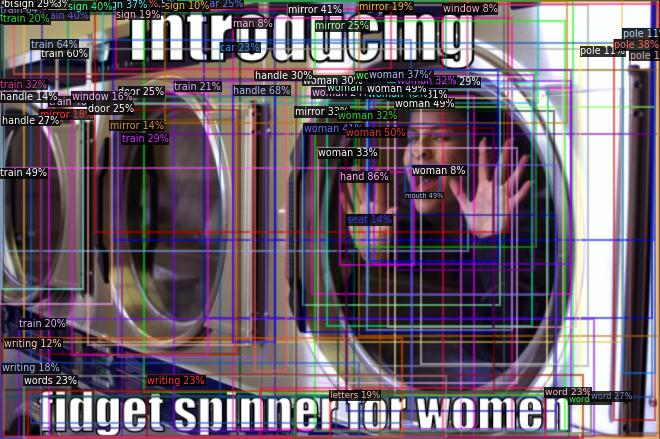

/content/drive/MyDrive/Colab Notebooks/data/img/14270.png


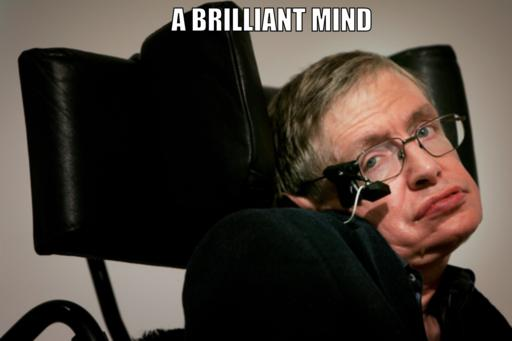

Original image size:  (341, 512)
Transformed image size:  (800, 1201)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


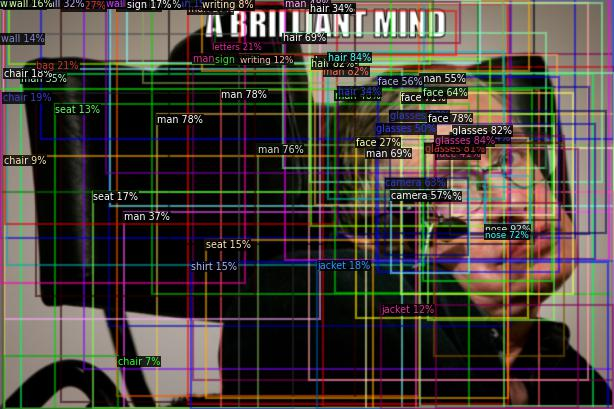

/content/drive/MyDrive/Colab Notebooks/data/img/76432.png


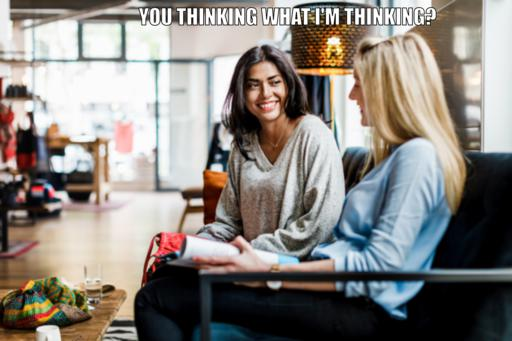

Original image size:  (341, 512)
Transformed image size:  (800, 1201)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


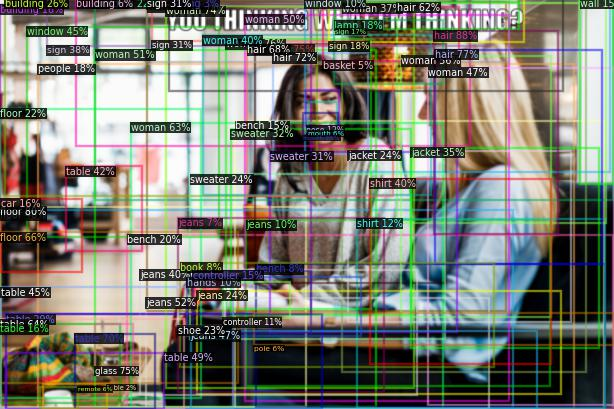

/content/drive/MyDrive/Colab Notebooks/data/img/38794.png


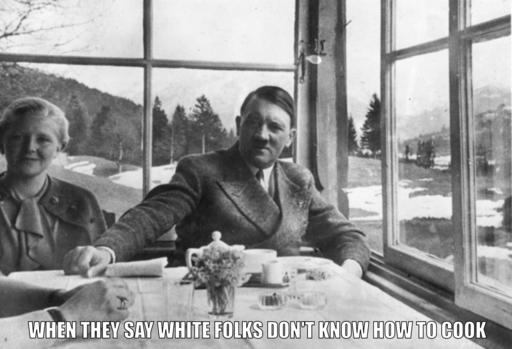

Original image size:  (349, 512)
Transformed image size:  (800, 1174)
Pooled features size: torch.Size([72, 2048])
torch.Size([72, 1601])


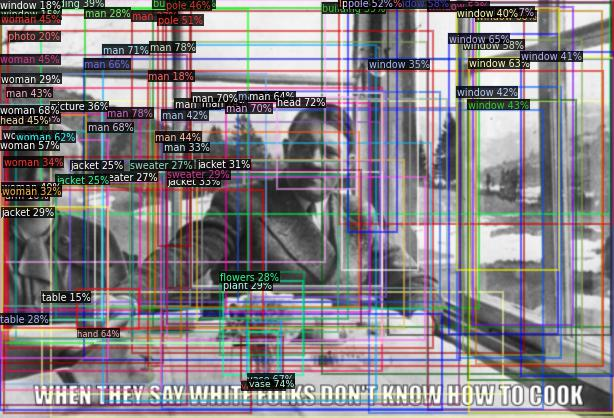

In [ ]:
#predit with boxes from tsv file and show image with boxes
NUM_OBJECTS = 72

from torch import nn

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image
from detectron2.structures.boxes import Boxes
from detectron2.structures.instances import Instances

def doit(raw_image, raw_boxes):
        # Process Boxes
    raw_boxes = Boxes(torch.from_numpy(raw_boxes).cuda())
    
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
        print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
        print("Transformed image size: ", image.shape[:2])
        
        # Scale the box
        new_height, new_width = image.shape[:2]
        scale_x = 1. * new_width / raw_width
        scale_y = 1. * new_height / raw_height
        #print(scale_x, scale_y)
        boxes = raw_boxes.clone()
        boxes.scale(scale_x=scale_x, scale_y=scale_y)
        
        # ----
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [boxes]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
        print('Pooled features size:', feature_pooled.shape)
        # Predict classes and boxes for each proposal.
        
        pred_class_logits, pred_proposal_deltas,_ = predictor.model.roi_heads.box_predictor(feature_pooled)
        print(pred_class_logits.shape)
        pred_class_prob = nn.functional.softmax(pred_class_logits, -1)
        pred_scores, pred_classes = pred_class_prob[..., :-1].max(-1)
        
        # Detectron2 Formatting (for visualization only)
        roi_features = feature_pooled
        instances = Instances(
            image_size=(raw_height, raw_width),
            pred_boxes=raw_boxes,
            scores=pred_scores,
            pred_classes=pred_classes
        )
        
        return instances, roi_features

for i, item in enumerate(data):
  img_file = os.path.join(data_path[1:-1], item['img_id'] + ".png")
  print(img_file)
  if os.path.exists(img_file):
    im = cv2.imread(img_file)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    showarray(im_rgb)
    instances, features = doit(im, item['boxes'])
    pred = instances.to('cpu')
    v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
    v = v.draw_instance_predictions(pred)
    showarray(v.get_image()[:, :, ::-1])
    if i > 10:
      break

